# CIFAR-10 с трюками

В этом задании мы продолжим работать с CIFAR-10, опробовав трюки, про которые мы узнали в 4 модуле.

Датасет CIFAR-10 состоит из цветных картинок 32x32, разделенных на 10 классов: 

__airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__

# Импорты

In [ ]:
!pip install -q tensorflow==2.1

     |████████████████████████████████| 421.8MB 18kB/s 
     |████████████████████████████████| 450kB 39.8MB/s 
     |████████████████████████████████| 3.9MB 39.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=298e247cf4a041f94631386786295da9cfedc03d5c92cc6a3b3a2c16fc22fd03
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

Init Plugin
Init Graph Optimizer
Init Kernel
2.5.0
2.5.0


# Загружаем данные

In [2]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
print("Трейн:", x_train.shape, y_train.shape)
print("Тест:", x_test.shape, y_test.shape)

Трейн: (50000, 32, 32, 3) (50000, 1)
Тест: (10000, 32, 32, 3) (10000, 1)


In [4]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

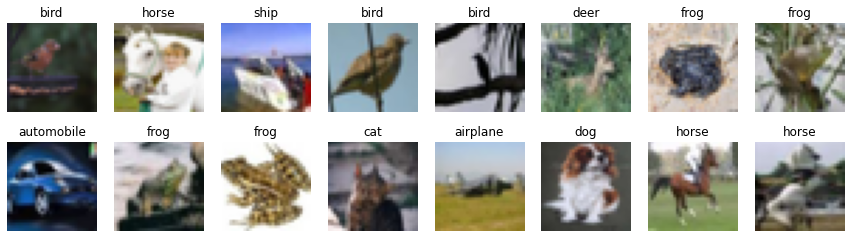

In [5]:
# посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Готовим данные

Не забудьте нормализовать картинки: $$x_{norm} = \frac{x}{255} - 0.5$$

А еще нужно превратить метки в one-hot вектора при помощи __keras.utils.to_categorical__.

In [6]:
# нормализуем входы
x_train2 = x_train.astype('float32') / 255 - 0.5
x_test2 = x_test.astype('float32') / 255 - 0.5

# конвертируем метки в np.array (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Задаем *дефолтную* архитектуру сети

In [7]:
# слои, которые нам пригодятся
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

Нам понадобятся такие слои:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - сверточный слой:
    - **filters**: количество фильтров на выходе; 
    - **kernel_size**: размер скользящего окна;
    - **padding**: padding="same" добивает нулями, чтобы ширина и высота на выходе не изменились, padding='valid' берет только окна, которые полностью помещаются в картинке;
    - **activation**: "relu", "tanh", итд;
    - **input_shape**: размер входа вида (W, H, C_in).
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - пулинг
- [Flatten](https://keras.io/layers/core/#flatten) - все оси, кроме батча (первой) вытягиваются в один вектор.
- [Dense](https://keras.io/layers/core/#dense) - плотный, активацию можно задать через activation="elu" или activation="softmax".
- [Dropout](https://keras.io/layers/core/#dropout) - дропаут регуляризация (без нее сеть сильно переобучается), позже узнаем какой у нее смысл.

Ваша модель должна принимать на вход цветную картинку __(None, 32, 32, 3)__ и предсказывать вероятности 10 классов __(None, 10)__.

Добавьте __4__ сверточных слоя с окном __(3, 3)__ с нарастающим количеством фильтров: __(16, 32, 32, 64)__, используйте "same" паддинг.

Добавьте __2x2__ макс пулинг после каждых 2 сверточных слоев (conv-conv-pool схема).

Используйте __activation='relu'__ для всех слоев, где это нужно.

Добавьте плотный слой из __256__ нейронов и еще один из __10__ нейронов для предсказания выходов. Не забудьте применить __Flatten__ перед первым плотным слоем!

Для регуляризации сети вставьте Dropout после каждого пулинг слоя (с параметром** 0.25**) и между плотными слоями на выходе (с параметром **0.5**).

В дальнейшем будем называть эту архитектуру **дефолтной** и будем исследовать небольшие изменения в ней!

In [14]:
def make_default_model():
    activation = 'relu'
    padding = 'same'
    input_shape=(32, 32, 3)
    model = Sequential()
    model.add(L.Conv2D(16, kernel_size=(3, 3) , strides=(1, 1), padding=padding, input_shape=input_shape))
    model.add(L.Conv2D(32, kernel_size=(3, 3) , strides=(1, 1), padding=padding, input_shape=input_shape))
    model.add(L.MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(.25))
    model.add(L.Conv2D(32, kernel_size=(3, 3) , strides=(1, 1), padding=padding, input_shape=input_shape))
    model.add(L.Conv2D(64, kernel_size=(3, 3) , strides=(1, 1), padding=padding, input_shape=input_shape))
    model.add(L.MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(.25))
    model.add(L.Flatten())
    model.add(Dense(256, activation='relu',)) # второй скрытый слой
    model.add(Dropout(.5))
    model.add(Dense(10, activation='softmax',)) # выходной слой
    
    return model

In [15]:
K.clear_session()
model = make_default_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

# Тренируем модель

In [17]:
def train_model(make_model_func=make_default_model, optimizer="sgd"):
  BATCH_SIZE = 32
  EPOCHS = 10

  K.clear_session()
  model = make_model_func()

  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy']
  )

  model.fit(
      x_train2, y_train2,  # нормализованные данные
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(x_test2, y_test2),
      shuffle=False
  )
  
  return model

Давайте посмотрим, что будет с дефолтной моделью (модель = make_default_model, оптимайзер = "adam"), если ее немного поменять:


Часть 1 :
1.   Какое качество (accuracy) на валидации дает **дефолтная архитектура**?

Часть 2:
2.   Измените в дефолтной архитектуре **relu активацию на sigmoid**, какое качество на валидации получили?
3.   Измените в дефолтной архитектуре **adam оптимайзер на sgd**, какое качество на валидации получили?
4.   Добавьте к дефолтной архитектуре **батч нормализацию** после каждого сверточного слоя и после перового полносвязного (model.add(BatchNormalization())), какое качество на валидации получили?
5.   Добавьте к дефолтной архитектуре **батч нормализацию** и смените **relu активацию на sigmoid**,  какое качество на валидации получили?
  
*Рекомендуется завести свою функцию для каждого изменения архитектуры!*


In [18]:
# учим дефолтную архитектуру
train_model()

Epoch 1/10
   4/1563 [..............................] - ETA: 27s - loss: 2.3412 - accuracy: 0.0781 

2022-03-21 15:49:07.587351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 1.7938 - accuracy: 0.3546

2022-03-21 15:49:24.755924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 19s 12ms/step - loss: 1.7938 - accuracy: 0.3546 - val_loss: 1.5021 - val_accuracy: 0.4706
Epoch 2/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.4296 - accuracy: 0.4940 - val_loss: 1.3347 - val_accuracy: 0.5297
Epoch 3/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.2076 - accuracy: 0.5761 - val_loss: 1.1793 - val_accuracy: 0.5848
Epoch 4/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.0287 - accuracy: 0.6404 - val_loss: 1.1030 - val_accuracy: 0.6113
Epoch 5/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.8679 - accuracy: 0.6984 - val_loss: 1.0676 - val_accuracy: 0.6306
Epoch 6/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.7059 - accuracy: 0.7593 - val_loss: 1.1178 - val_accuracy: 0.6349
Epoch 7/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.5388 - accuracy: 0.8217 - val_loss: 1.2257 - val_accura

In [ ]:
def make_sigmoid_model():
    ...

In [ ]:
# учим sigmoid
train_model(make_sigmoid_model)

In [ ]:
# учим sgd
train_model(optimizer="sgd")

In [ ]:
def make_bn_model():
    ...

In [ ]:
# учим bn
train_model(make_bn_model)

In [ ]:
def make_sigmoid_bn_model():
    ...

In [ ]:
# учим sigmoid + bn
train_model(make_sigmoid_bn_model)